###  Libraries

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from Initialization import Initialization
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()

### Load Dataset

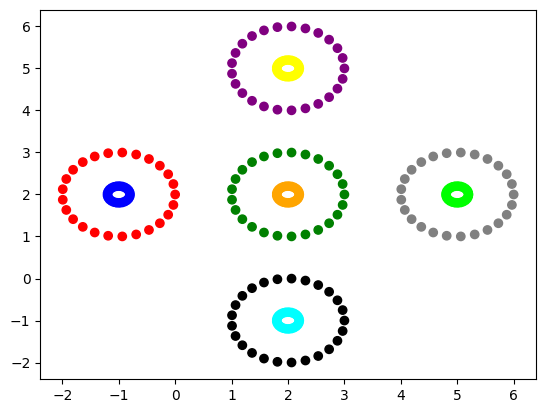

In [3]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2)]  # Specify center positions for each pair
#centers_coordinates = [(2, 2), (-2, 2)]
rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=50, factor=0.2, noise=0.0)
#X, y = rings.remove_samples_with_specific_label(X, y, 3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [4]:
K = 10
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### kMeans

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ACC: 0.68 PUR: 0.68 NMI: 0.80 ARI: 0.58


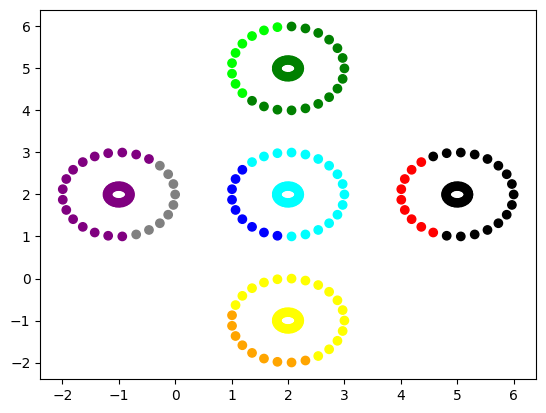

In [5]:
kmeans = KMeans(n_clusters=K).fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

C:\Users\APDHP-DM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 250 1-dimensional timeseries
  warnings.warn(


ACC: 0.72 PUR: 0.72 NMI: 0.81 ARI: 0.59


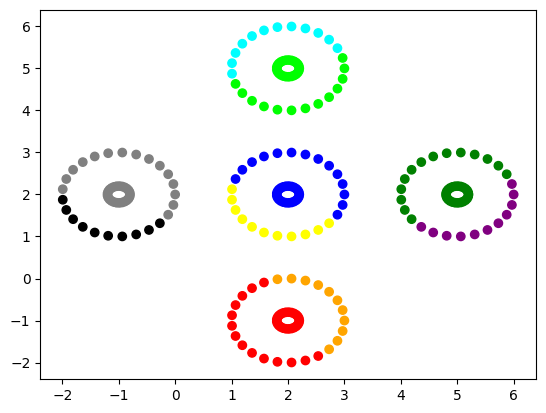

In [6]:
kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
plt.show()

### Kernel kMeans++

Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initialization
Executing Kernel k-Means++ Initial

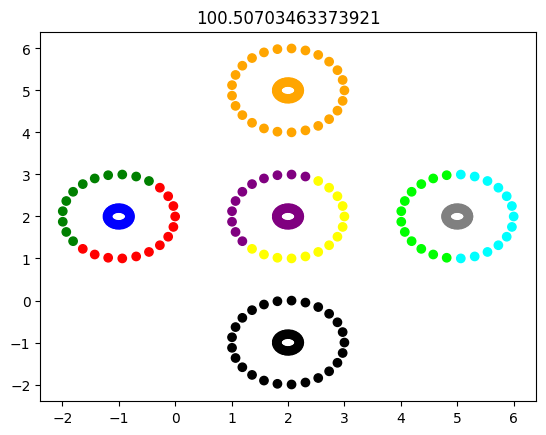

95.86221925074655

In [7]:
kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=50, init='k-means++')
kernelKMeans.fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kernelKMeans.labels_, cmap=ListedColormap(colors))
plt.title(kernelKMeans.inertia_)
plt.show()
# That's the function of grount truth error
kernelKMeans.calculate_ground_truth_error(y)

### Global Kernel kMeans

ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00


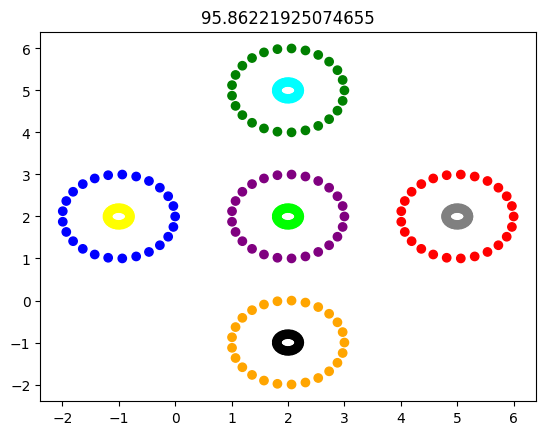

In [8]:
globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix)
globalKernelKMeans.fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeans.labels_[K], cmap=ListedColormap(colors))
plt.title(globalKernelKMeans.inertia_[K])
plt.show()

### Global Kernel kMeans++

ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00


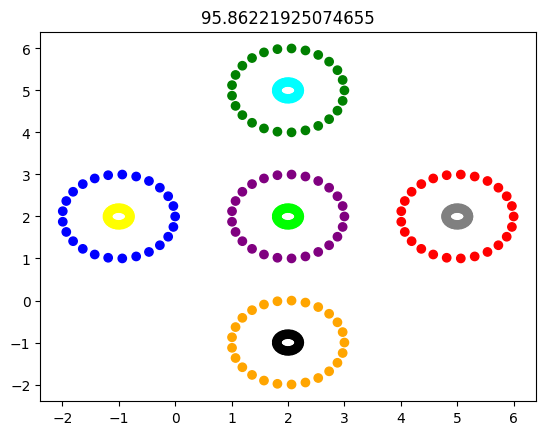

In [9]:
globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=250, sampling='sequential', tol=1e-4, verbose=0)
globalKernelKMeansPP.fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeansPP.labels_[K], cmap=ListedColormap(colors))
plt.title(globalKernelKMeansPP.inertia_[K])
plt.show()